In [2]:
# Load packages and directories

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)


import os
import numpy as np
import pandas as pd
# import plotly.graph_objects as go
# import plotly.offline as pyo
# import plotly.subplots as sp
# import numpy as np
# import random
import matplotlib.pyplot as plt
# import plotly.express as px
# import tslearn.clustering as tsc

# from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
# import sklearn.preprocessing as pr
# import sklearn.metrics as mt
import seaborn as sns
# from scipy.stats import chi2_contingency
# from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, normalize, Normalizer

# from tslearn.utils import to_time_series_dataset
# from tslearn.clustering import TimeSeriesKMeans
# from tslearn.datasets import CachedDatasets
# from tslearn.preprocessing import TimeSeriesScalerMeanVariance, TimeSeriesScalerMinMax
# from tslearn.barycenters import softdtw_barycenter 
import matplotlib.patches as mpatches
# from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score, pairwise_distances_argmin_min
# from sklearn_extra.cluster import KMedoids 
# from fastdtw import fastdtw
# from scipy.spatial.distance import euclidean
# from scipy.cluster.hierarchy import dendrogram, linkage,  single, complete, average, ward, fcluster
# from tslearn.metrics import dtw, cdist_dtw
import importlib
import clustering_processing2, preprocessing, cluster_grid

base_directory = "C:/Users/CEEM04/OneDrive-Emily/OneDrive - UNSW/edpdatacleaning"
data_directory = os.path.join(base_directory, 'edp_data')
cleaned_data_directory = os.path.join(base_directory, 'resampled_30min_data')

# Directory containing the household profile CSV files
survey_data = pd.read_csv(os.path.join(base_directory, 'survey/edp_survey_aircon.csv'))  
output_directory = os.path.join(base_directory, 'figures')  # Change this to your output directory

climate_zone_descriptions = {
    1: 'High humidity summer, warm winter (Zone 1)',
    2: 'Warm humid summer, mild winter (Zone 2)',
    3: 'Hot dry summer, warm winter (Zone 3)',
    4: 'Hot dry summer, cool winter (Zone 4)',
    5: 'Warm temperate (Zone 5)',
    6: 'Mild temperate (Zone 6)',
    7: 'Cool temperate (Zone 7)',
    8: 'Alpine (Zone 8)'
}

survey_data['climate_zone'] = survey_data['climate_zone'].map(climate_zone_descriptions)

In [3]:
importlib.reload(preprocessing)
from preprocessing import create_combined_df, create_combined_df_UNNORMALIZED

# create combined_df
# Directory containing the household CSV files
data_dir = cleaned_data_directory

# Create a complete date range for 2023 in 30-minute increments
date_range = pd.date_range(start='2023-01-01 00:00:00', end='2023-12-31 23:30:00', freq='30T')

combined_df = create_combined_df_UNNORMALIZED(cleaned_data_directory, date_range)
# Define the path for the CSV file
csv_path = os.path.join(base_directory, 'combined_aircon_profiles.csv')

# # Write to CSV only if the file doesn't already exist
if not os.path.exists(csv_path):
    combined_df.to_csv(csv_path, index=False)
    print(f'File written: {csv_path}')
else:
    print('File already exists!')

#print(combined_df['W0314'])



File already exists!


In [16]:

def calculate_daily_consumption(combined_df):
    """
    Calculate the daily energy consumption for each household, returning NaN for days with incomplete data.

    Parameters:
    combined_df (pd.DataFrame): DataFrame with timestamps as rows and columns as household energy consumption.

    Returns:
    pd.DataFrame: DataFrame with daily energy consumption for each household.
    """
    # Ensure the 'Timestamp' column is parsed as datetime and set as index
    combined_df['Timestamp'] = pd.to_datetime(combined_df['Timestamp'])
    combined_df = combined_df.set_index('Timestamp')
    
    # Resample the data to daily frequency and sum the energy consumption
    daily_consumption_df = combined_df.resample('D').sum()
    
    # Check for days with incomplete data and set them to NaN
    counts = combined_df.resample('D').count()
    daily_consumption_df[counts < 48] = float('NaN')
    
    return daily_consumption_df

# Example usage
# Assuming combined_df is defined somewhere in your code
# Example: combined_df = pd.read_csv('your_combined_data.csv', index_col='Timestamp', parse_dates=True)

daily_consumption_df = calculate_daily_consumption(combined_df)


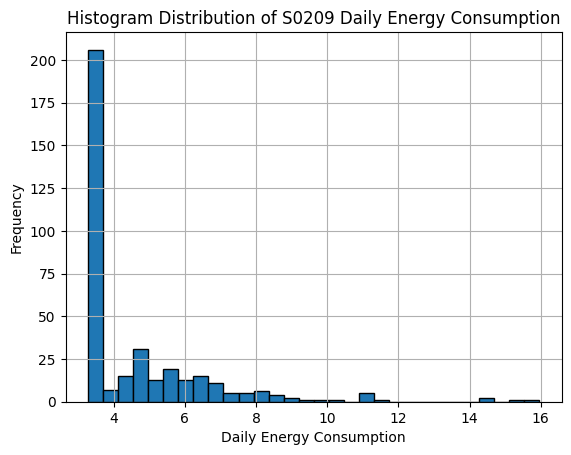

In [35]:
# summary = daily_consumption_df.describe()
# print(summary)

import pandas as pd
import matplotlib.pyplot as plt

# Assuming daily_consumption_df is already defined and contains the 'S0024' column

daily_consumption_df_modified = daily_consumption_df.copy()
# Modify any values below 1 kWh to be NaN
daily_consumption_df_modified = daily_consumption_df_modified.applymap(lambda x: x if x >= 0 else float('NaN'))

# Plot the histogram distribution of the 'S0024' column
daily_consumption_df_modified['S0209'].hist(bins=30, edgecolor='black')

# Add titles and labels
plt.title('Histogram Distribution of S0209 Daily Energy Consumption')
plt.xlabel('Daily Energy Consumption')
plt.ylabel('Frequency')

# Show the plot
plt.show()

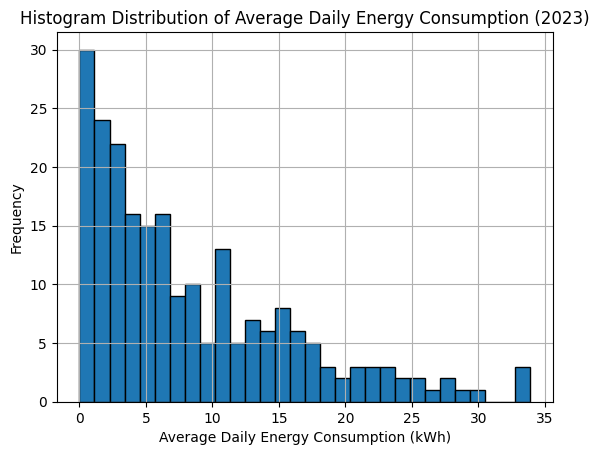

In [18]:

# Assuming daily_consumption_df is already defined

# Create a copy of the DataFrame to modify
#daily_consumption_df_modified = daily_consumption_df_modified.copy()

# Apply the mask to all columns in the DataFrame
daily_consumption_df_modified = daily_consumption_df_modified.applymap(lambda x: x if x >= 0 else float('NaN'))

# Calculate the average daily consumption for each site
average_daily_consumption = daily_consumption_df_modified.mean()

# Convert the result to a DataFrame for better readability
average_daily_consumption_df = average_daily_consumption.to_frame(name='average_daily_consumption')

# Display the average daily consumption DataFrame
average_daily_consumption_df['average_daily_consumption'].hist(bins=30, edgecolor='black')

# Add titles and labels
plt.title('Histogram Distribution of Average Daily Energy Consumption (2023)')
plt.xlabel('Average Daily Energy Consumption (kWh)')
plt.ylabel('Frequency')

# Show the plot
plt.show()

In [8]:

survey_with_station = pd.read_csv("survey/survey_with_station.csv")
# Reset index to turn the site IDs into a column
average_daily_consumption_df.reset_index(inplace=True)
average_daily_consumption_df.rename(columns={'index': 'edp_site_id'}, inplace=True)

# Merge the survey_with_station DataFrame with the average_daily_consumption_df DataFrame on site_ID
merged_df = pd.merge(average_daily_consumption_df, survey_with_station, on='edp_site_id', how='left')


In [23]:
merged_df = merged_df[['edp_site_id', 'average_daily_consumption', 'aircon_type_simplified', 'property_construction', 'num_occupants', 'climate_zone']]
# change climate zone column to category type
merged_df['climate_zone'] = merged_df['climate_zone'].astype('category')

In [10]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.diagnostic import het_white
from statsmodels.regression.quantile_regression import QuantReg


In [24]:
formula = "average_daily_consumption  ~ aircon_type_simplified + property_construction + num_occupants + climate_zone"
ols = smf.ols(formula, merged_df).fit()


In [25]:
white_test = het_white(ols.resid,  ols.model.exog)
bp_test = het_breuschpagan(ols.resid, ols.model.exog)

labels = ['LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test p-value']
print(dict(zip(labels, bp_test)))
print(dict(zip(labels, white_test)))

{'LM Statistic': 20.512807488829885, 'LM-Test p-value': 0.2488432937417436, 'F-Statistic': 1.2216840524606167, 'F-Test p-value': 0.24974755466130652}
{'LM Statistic': 77.18109241704195, 'LM-Test p-value': 0.260035709505872, 'F-Statistic': 1.1496471351196478, 'F-Test p-value': 0.23856383484120627}


In [26]:

import statsmodels.api as sm
from statsmodels.regression.quantile_regression import QuantReg
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

def compare_regressions(df, y_col, numeric_predictors, categorical_predictors, quantiles=[0.25, 0.5, 0.75]):
    """
    Compare OLS and Quantile Regression for a dataset with preprocessing
    
    Parameters:
    df: pandas DataFrame
    y_col: str, name of response variable
    numeric_predictors: list of str, names of numeric predictor columns
    categorical_predictors: list of str, names of categorical predictor columns
    quantiles: list of float, quantiles to evaluate
    """
    # Create a copy to avoid modifying original data
    df_clean = df.copy()
    
    # Handle missing values
    print("\nMissing values before cleaning:")
    print(df_clean.isnull().sum())
    
    # For numeric columns, fill NA with median
    for col in numeric_predictors:
        df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')
        df_clean[col] = df_clean[col].fillna(df_clean[col].median())
    
    # For categorical columns, fill NA with mode
    for col in categorical_predictors:
        df_clean[col] = df_clean[col].fillna(df_clean[col].mode()[0])
    
    # Convert response variable to numeric
    df_clean[y_col] = pd.to_numeric(df_clean[y_col], errors='coerce')
    df_clean = df_clean.dropna(subset=[y_col])
    
    
    # Create dummy variables for categorical predictors
    X = pd.get_dummies(df_clean[categorical_predictors], drop_first=True) if categorical_predictors else pd.DataFrame(index=df_clean.index)
    if numeric_predictors:
        X = pd.concat([X, df_clean[numeric_predictors]], axis=1)
    
    # Convert boolean columns to int
    bool_cols = X.select_dtypes(include=['bool']).columns
    for col in bool_cols:
        X[col] = X[col].astype(int)
    
    # Add constant
    X = sm.add_constant(X)
    y = df_clean[y_col]
    
    # Print data info
    print("\nFeature matrix shape:", X.shape)
    print("Response vector shape:", y.shape)
    print("\nFeature matrix preview:")
    print(X.head())
    print("\nData types in X:")
    print(X.dtypes)
    print("\nData type of y:", y.dtype)
    
    # Fit OLS
    ols_model = sm.OLS(y, X).fit()
    ols_pred = ols_model.predict(X)
    
    # Fit Quantile Regression for different quantiles
    qr_models = {}
    qr_preds = {}
    for q in quantiles:
        qr_model = QuantReg(y, X).fit(q=q)
        qr_models[q] = qr_model
        qr_preds[q] = qr_model.predict(X)
    
    # Diagnostic plots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. Residuals vs Fitted
    axes[0,0].scatter(ols_pred, ols_model.resid, alpha=0.5)
    axes[0,0].axhline(y=0, color='r', linestyle='--')
    axes[0,0].set_xlabel('Fitted values')
    axes[0,0].set_ylabel('Residuals')
    axes[0,0].set_title('OLS: Residuals vs Fitted')
    
    # 2. Q-Q plot
    stats.probplot(ols_model.resid, dist="norm", plot=axes[0,1])
    axes[0,1].set_title('OLS: Q-Q Plot')
    
    # 3. Actual vs Predicted
    axes[1,0].scatter(y, ols_pred, alpha=0.5, label='OLS')
    for q in quantiles:
        axes[1,0].scatter(y, qr_preds[q], alpha=0.5, label=f'QR {q}')
    axes[1,0].plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
    axes[1,0].set_xlabel('Actual')
    axes[1,0].set_ylabel('Predicted')
    axes[1,0].set_title('Actual vs Predicted')
    axes[1,0].legend()
    
    # 4. Residual density plot
    residuals = pd.DataFrame({
        'OLS': ols_model.resid,
        **{f'QR {q}': y - qr_preds[q] for q in quantiles}
    })
    for col in residuals.columns:
        sns.kdeplot(data=residuals[col], ax=axes[1,1], label=col)
    axes[1,1].set_title('Residual Density Plot')
    axes[1,1].legend()
    
    plt.tight_layout()
    
    # Print model summaries and metrics
    print("\nOLS Summary:")
    print(ols_model.summary().tables[1])
    print("\nQuantile Regression Summaries:")
    for q in quantiles:
        print(f"\nQuantile {q}:")
        print(qr_models[q].summary().tables[1])
    
    # Calculate metrics
    metrics = pd.DataFrame({
        'OLS': {
            'R-squared': ols_model.rsquared,
            'MSE': np.mean(ols_model.resid**2),
            'MAE': np.mean(np.abs(ols_model.resid)),
            'Shapiro-Wilk p-value': stats.shapiro(ols_model.resid)[1]
        },
        **{f'QR {q}': {
            'R-squared': 1 - np.sum(np.abs(y - qr_preds[q])) / np.sum(np.abs(y - np.median(y))),
            'MSE': np.mean((y - qr_preds[q])**2),
            'MAE': np.mean(np.abs(y - qr_preds[q])),
            'Shapiro-Wilk p-value': stats.shapiro(y - qr_preds[q])[1]
        } for q in quantiles}
    })
    
    print("\nModel Comparison Metrics:")
    print(metrics)
    
    return ols_model, qr_models, metrics, fig, X, y


Missing values before cleaning:
edp_site_id                  0
average_daily_consumption    0
aircon_type_simplified       1
property_construction        0
num_occupants                0
climate_zone                 0
dtype: int64

Feature matrix shape: (223, 14)
Response vector shape: (223,)

Feature matrix preview:
   const  aircon_type_simplified_Split System  \
0    1.0                                    0   
1    1.0                                    1   
2    1.0                                    0   
3    1.0                                    1   
4    1.0                                    0   

   aircon_type_simplified_Wall / window mounted aircon  \
0                                                  0     
1                                                  0     
2                                                  0     
3                                                  0     
4                                                  0     

   property_construction_Concrete  p

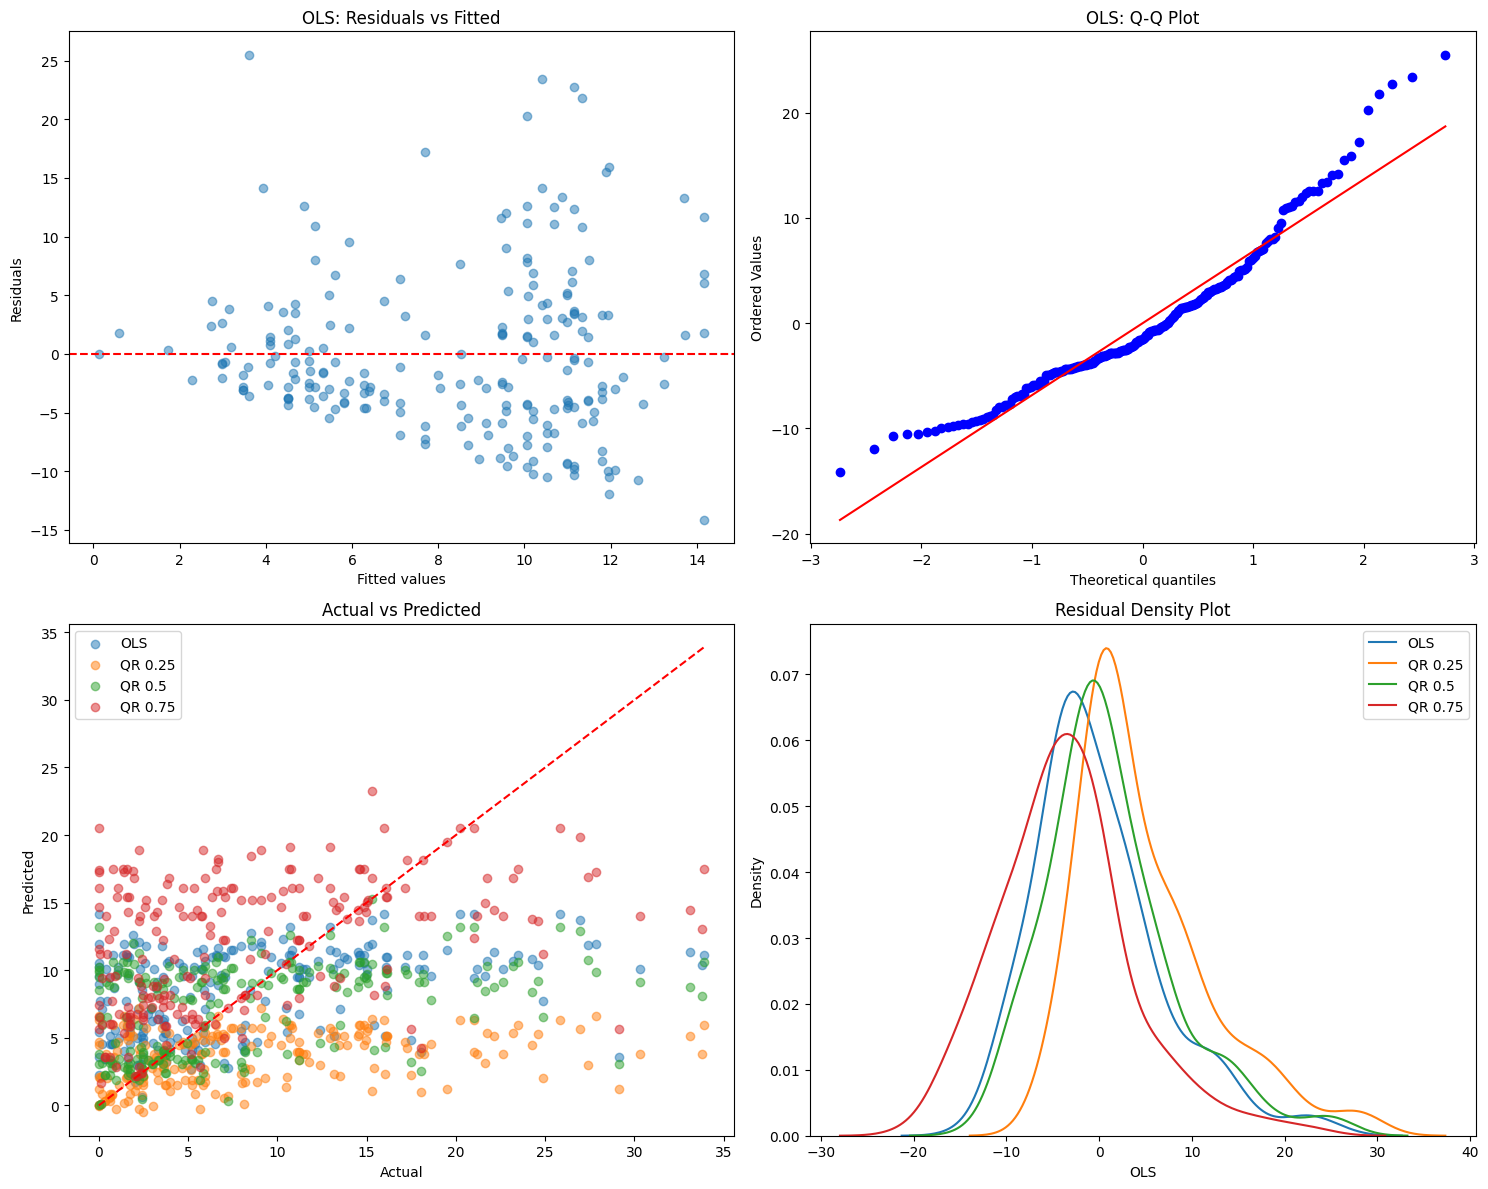


Metrics comparison:
                               OLS       QR 0.25        QR 0.5    QR 0.75
R-squared             1.713615e-01 -9.183040e-04  1.238913e-01  -0.094453
MSE                   4.875683e+01  7.572209e+01  5.102026e+01  65.538951
MAE                   5.346484e+00  5.847209e+00  5.118091e+00   6.393622
Shapiro-Wilk p-value  4.062234e-08  2.913881e-11  6.712200e-08   0.000056


In [27]:
# Correct way to unpack all returned values
ols_model, qr_models, metrics, fig, X, y = compare_regressions(
    df=merged_df,
    y_col='average_daily_consumption',
    numeric_predictors=['num_occupants'],
    categorical_predictors=['aircon_type_simplified', 'property_construction', 'climate_zone']
)

# Display the results
plt.show()  # Show the diagnostic plots
print("\nMetrics comparison:")
print(metrics)

Not normal, heteroskedastic 

In [28]:

def create_regression_summary(ols_model, qr_models, alpha=0.05):
    """
    Create a summary table of regression results with significance stars
    
    Parameters:
    ols_model: statsmodels OLS results
    qr_models: dict of quantile regression results
    alpha: significance level for p-values (default 0.05)
    """
    
    def add_stars(coef, pval):
        """Add significance stars to coefficient"""
        coef_str = f"{coef:.3f}"
        if pval < alpha:
            coef_str += "*"
        return coef_str
    
    # Get OLS results
    ols_coef = ols_model.params
    ols_pvals = ols_model.pvalues
    
    # Create results dictionary
    results = {'OLS': {}}
    
    # Add OLS coefficients with stars
    for var in ols_coef.index:
        results['OLS'][var] = add_stars(ols_coef[var], ols_pvals[var])
    
    # Add quantile regression results
    for q, model in qr_models.items():
        q_coef = model.params
        q_pvals = model.pvalues
        results[f'Q{int(q*100)}'] = {}
        
        for var in q_coef.index:
            results[f'Q{int(q*100)}'][var] = add_stars(q_coef[var], q_pvals[var])
    
    # Create DataFrame
    results_df = pd.DataFrame(results).round(3)
    
    # Add p-values
    p_values = pd.DataFrame({
        'OLS_pval': ols_pvals,
        **{f'Q{int(q*100)}_pval': model.pvalues for q, model in qr_models.items()}
    }).round(3)
    
    # Combine results
    final_df = pd.concat([results_df, p_values], axis=1)
    
    # Add section for model fit statistics
    fit_stats = pd.DataFrame({
        'OLS': {
            'R-squared': ols_model.rsquared,
            'Adj. R-squared': ols_model.rsquared_adj,
            'F-statistic': ols_model.fvalue,
            'F p-value': ols_model.f_pvalue,
            'Log-likelihood': ols_model.llf,
            'AIC': ols_model.aic,
            'BIC': ols_model.bic,
            'N': ols_model.nobs
        },
        **{f'Q{int(q*100)}': {
            'R-squared': np.nan,
            'Adj. R-squared': np.nan,  # Not applicable for quantile regression
            'F-statistic': np.nan,
            'F p-value': np.nan,
            'Log-likelihood': np.nan,
            'AIC': np.nan,
            'BIC': np.nan,
            'N': model.nobs
        } for q, model in qr_models.items()}
    }).round(3)
    
    # Format the tables
    coef_table = results_df.copy()
    coef_table.index.name = 'Variable'
    coef_table = coef_table.reset_index()
    
    p_value_table = p_values.copy()
    p_value_table.index.name = 'Variable'
    p_value_table = p_value_table.reset_index()
    
    fit_stats_table = fit_stats.copy()
    fit_stats_table.index.name = 'Statistic'
    fit_stats_table = fit_stats_table.reset_index()
    
    return {
        'coefficients': coef_table,
        'p_values': p_value_table,
        'fit_statistics': fit_stats_table
    }

# Example usage:
def print_regression_summary(ols_model, qr_models):
    """
    Print formatted regression summary tables
    """
    summary = create_regression_summary(ols_model, qr_models)
    
    print("\nRegression Coefficients (with significance stars for p < 0.05):")
    print("=" * 80)
    print(summary['coefficients'].to_string(index=False))
    
    print("\nP-values:")
    print("=" * 80)
    print(summary['p_values'].to_string(index=False))
    
    print("\nModel Fit Statistics:")
    print("=" * 80)
    print(summary['fit_statistics'].to_string(index=False))
    
    print("\nNote: * indicates significance at p < 0.05")

In [29]:
print_regression_summary(ols_model, qr_models)


Regression Coefficients (with significance stars for p < 0.05):
                                           Variable     OLS     Q25     Q50     Q75
                                              const 15.550*   3.412 15.484* 22.018*
                aircon_type_simplified_Split System -5.535* -2.985* -6.028* -7.950*
aircon_type_simplified_Wall / window mounted aircon  -5.479  -0.325  -5.022 -8.436*
                     property_construction_Concrete  -2.483   0.020  -1.637  -5.316
                   property_construction_Don't know   0.492  -3.919   2.719   4.089
                 property_construction_Double brick   0.812   0.627  -0.751  -0.216
                  property_construction_Lightweight  -1.529  -1.124  -1.225 -3.181*
                        property_construction_Other  -2.710  -1.450  -3.421  -0.218
                                     climate_zone_2  -5.850  -1.093  -6.731  -5.970
                                     climate_zone_4  -9.776  -1.092  -9.079 -11.302
           

Now, we want to try using GAMLSS to predict the daily aircon electricity consumption's distribution for a household

Generalized Additive Models of Location Scale and Shape (GAMLSS) are an extension of Generalized Additive Models (GAM), which are an extension of generalized linear models. The most important feature of the GAMLSS is that they can be used to model multi-parameter distributions, meaning we can specify models for each of location, scale, shape and skewness. This flexibility allows the GAMLSS to overcome the homoskedasticity and gaussian noise assumptions of the GP & SVGP models. 

In [30]:
# reformat the data to look at each daily data point instead of an average
df_long = daily_consumption_df_modified.reset_index().melt(id_vars=['Timestamp'], var_name='edp_site_id', value_name='daily_kWh_consumption')
df_combined_long = pd.merge(df_long, survey_with_station, on='edp_site_id', how='left')
df_combined_long = df_combined_long[['Timestamp', 'edp_site_id', 'daily_kWh_consumption', 'aircon_type_simplified', 'property_construction', 'num_occupants', 'climate_zone']]


In [10]:
# Define the path for the CSV file
csv_path_combined_long = os.path.join(base_directory, 'df_combined_long.csv')

# Write the DataFrame to a CSV file
df_combined_long.to_csv(csv_path_combined_long, index=False)

print(f'File written: {csv_path_combined_long}')

File written: C:/Users/CEEM04/OneDrive-Emily/OneDrive - UNSW/edpdatacleaning\df_combined_long.csv


([<matplotlib.axis.XTick at 0x2bbcb2773b0>,
 [Text(1, 0, '5'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '6'),
  Text(5, 0, '1')])

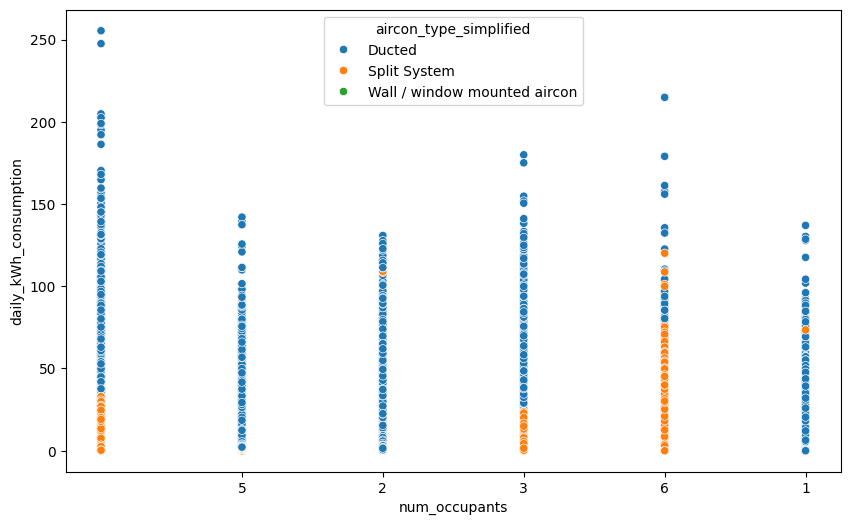

In [122]:
# create a scatterplot of df_combined_long with y as the value and x as num_occupants
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_combined_long, x='num_occupants', y='daily_kWh_consumption', hue='aircon_type_simplified')
# order x axis by num_occupants

<Axes: xlabel='daily_kWh_consumption', ylabel='Count'>

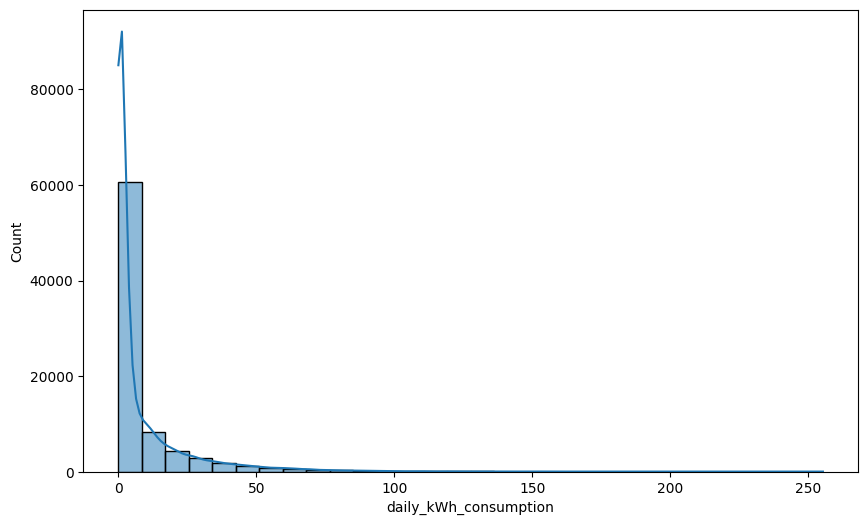

In [31]:
# create a histogram of daily_kWh_consumption
plt.figure(figsize=(10, 6))
sns.histplot(data=df_combined_long, x='daily_kWh_consumption', bins=30, kde=True)

In [ ]:
# find best fit distribution of daily_kWh_consumption
from distfit import distfit

dist = distfit()        # Initialize 
# remove NA values from the daily_kWh_consumption column
df_combined_long = df_combined_long.dropna(subset=['daily_kWh_consumption'])
# remove rows where daily_kWh_consumption is less than 1
df_combined_long = df_combined_long[df_combined_long['daily_kWh_consumption'] >= 1]
dist.fit_transform(df_combined_long['daily_kWh_consumption'].values)   # Fit distributions on empirical data X
dist.predict(df_combined_long['daily_kWh_consumption'].values)         # Predict the probability of the resonse variables
dist.plot()
